# AXPY Scaling

**(memory bandwidth vs number of threads)**

Unfortunately, we can't change the number of Julia threads dynamically (e.g. in a Jupyter session).

**Poor-man's workaround:**
* Start Julia with 128 threads (= # CPU-cores) and 
* dynamically choose how many of them to use in `measure_perf`.

<div style="color: #AA0000"><b>Make sure to use the Julia kernel with 128 threads for this notebook !!!</b></div>

How to run a computation on `n <= nthreads()` Julia threads?

**Idea:** Use `@threads :static for i in 1:n` to create `n` tasks that get statically scheduled to the first `n` Julia threads.

In [1]:
using Base.Threads: @threads, nthreads, threadid

function example(; numthreads=nthreads())
    @threads :static for tid in 1:numthreads
        println("Doing work on thread $tid ($(threadid()))")
    end
end

example (generic function with 1 method)

In [2]:
example(; numthreads=2)

Doing work on thread 2 (2)
Doing work on thread 1 (1)


In [3]:
example(; numthreads=5)

Doing work on thread 1 (1)
Doing work on thread 3 (3)
Doing work on thread 5 (5)
Doing work on thread 4 (4)
Doing work on thread 2 (2)


What if I want to work on data (of dynamic size)? → [ChunkSplitters.jl](https://github.com/m3g/ChunkSplitters.jl) or `Iterators.partition`

In [4]:
using ChunkSplitters

In [5]:
chunks(1:12, 2) |> collect

2-element Vector{Tuple{StepRange{Int64, Int64}, Int64}}:
 (1:1:6, 1)
 (7:1:12, 2)

In [6]:
chunks(1:12, 3) |> collect

3-element Vector{Tuple{StepRange{Int64, Int64}, Int64}}:
 (1:1:4, 1)
 (5:1:8, 2)
 (9:1:12, 3)

In [7]:
using Base.Threads: @threads, nthreads

function example(data; numthreads=nthreads())
    @threads :static for (idcs, tid) in chunks(data, numthreads)
        println("Doing work on thread $tid")
        for i in idcs
            # do work...
        end
    end
end

example (generic function with 2 methods)

In [8]:
example(rand(100); numthreads=2)

Doing work on thread 2
Doing work on thread 1


In [9]:
example(rand(100); numthreads=10)

Doing work on thread 2
Doing work on thread 6
Doing work on thread 5
Doing work on thread 7
Doing work on thread 1
Doing work on thread 9
Doing work on thread 8
Doing work on thread 3
Doing work on thread 4
Doing work on thread 10


### AXPY with `numthreads` option

Let's rewrite our axpy examples in terms of chunks (one per task/thread), so that we can add a `numthreads` option to `measure_perf` similar to the `example` function above.

In [10]:
using BenchmarkTools
using Random

function axpy_static_chunks!(y, a, x; chunks)
    @threads :static for (idcs, tid) in chunks   # iterating over chunks (i.e. tasks/threads)
        @simd for i in idcs                      # each thread processes the assigned range of idices
            @inbounds y[i] = a * x[i] + y[i]
        end
    end
    return nothing
end

function generate_input_data_chunks(; N, dtype, parallel=false, static=false, chunks, kwargs...)
    a = dtype(3.141)
    x = Vector{dtype}(undef, N)
    y = Vector{dtype}(undef, N)
    if !parallel
        rand!(x)
        rand!(y)
    else
        if !static
            @threads for (idcs, tid) in chunks             # new: same as above
                @inbounds for i in idcs
                    x[i] = rand()
                    y[i] = rand()
                end
            end
        else
            @threads :static for (idcs, tid) in chunks     # new: same as above
                @inbounds for i in idcs
                    x[i] = rand()
                    y[i] = rand()
                end
            end
        end
    end
    return a,x,y
end

function measure_perf_chunks(; N=2^27, dtype=Float64, verbose=true, numthreads=Threads.nthreads(), kwargs...)
    # input data
    cs = chunks(1:N, numthreads) # new: chunking
    a, x, y = generate_input_data_chunks(; N, dtype, chunks=cs, kwargs...)

    # time measurement
    t = @belapsed axpy_static_chunks!($y, $a, $x; chunks=$cs) evals = 2 samples = 10

    # compute memory bandwidth and flops
    bytes = 3 * sizeof(dtype) * N
    flops = 2 * N
    mem_rate = bytes * 1e-9 / t
    flop_rate = flops * 1e-9 / t

    if verbose
        println("Dtype: $dtype")
        println("\tMemory Bandwidth (GB/s): ", round(mem_rate; digits=2))
        println("\tCompute (GFLOP/s): ", round(flop_rate; digits=2))
    end
    return mem_rate, flop_rate
end

measure_perf_chunks (generic function with 1 method)

In [11]:
using ThreadPinning
pinthreads(:numa)

measure_perf_chunks(; numthreads=1, parallel=true, static=true);
measure_perf_chunks(; numthreads=8, parallel=true, static=true);

Dtype: Float64
	Memory Bandwidth (GB/s): 37.12
	Compute (GFLOP/s): 3.09
Dtype: Float64
	Memory Bandwidth (GB/s): 301.96
	Compute (GFLOP/s): 25.16


We are now in the position to run a small scaling analysis.

### Scaling analysis: tabular

In [12]:
using PrettyTables

function axpy_scaling_table(; numthreads=1:nthreads(), kwargs...)
    for nt in numthreads
        membw_results = Matrix{Float64}(undef, 3, 2)
        for (i, pin) in enumerate((:cores, :sockets, :numa))
            for (j, parallel) in enumerate((false, true))
                pinthreads(pin)
                membw, flops = measure_perf_chunks(; numthreads=nt, parallel=parallel, static=true, verbose=false, kwargs...)
                membw_results[i, j] = round(membw; digits=2)
            end
        end
        
        # (pretty) printing
        println()
        pretty_table(membw_results;
            header=[":serial", ":parallel"],
            row_names=[":cores", ":sockets", ":numa"],
            row_name_column_title="# Threads = $nt",
            title="Memory Bandwidth (GB/s)")
    end
end

axpy_scaling_table (generic function with 1 method)

In [13]:
 # should take around 3 min
@time axpy_scaling_table(; numthreads=[1, 8, 64, 128], N=2^30)


Memory Bandwidth (GB/s)
┌───────────────┬─────────┬───────────┐
│ # Threads = 1 │ :serial │ :parallel │
├───────────────┼─────────┼───────────┤
│        :cores │   38.87 │     37.87 │
│      :sockets │   38.41 │     37.75 │
│         :numa │   37.45 │     37.84 │
└───────────────┴─────────┴───────────┘

Memory Bandwidth (GB/s)
┌───────────────┬─────────┬───────────┐
│ # Threads = 8 │ :serial │ :parallel │
├───────────────┼─────────┼───────────┤
│        :cores │   38.08 │     38.22 │
│      :sockets │   38.63 │     80.31 │
│         :numa │   38.82 │    298.87 │
└───────────────┴─────────┴───────────┘

Memory Bandwidth (GB/s)
┌────────────────┬─────────┬───────────┐
│ # Threads = 64 │ :serial │ :parallel │
├────────────────┼─────────┼───────────┤
│         :cores │   37.62 │    157.58 │
│       :sockets │   35.32 │    157.66 │
│          :numa │   35.62 │    303.85 │
└────────────────┴─────────┴───────────┘

Memory Bandwidth (GB/s)
┌─────────────────┬─────────┬───────────┐
│ # Threads

### Scaling analysis: plot

In [14]:
using Plots

function axpy_scaling_plot(; numthreads=1:nthreads(), kwargs...)
    membws = Dict{Symbol, Vector{Float64}}()
    membws[:cores] = zeros(length(numthreads))
    membws[:sockets] = zeros(length(numthreads))
    membws[:numa] = zeros(length(numthreads))
    
    for (t, nt) in enumerate(numthreads)
        for (p, pin) in enumerate((:cores, :sockets, :numa))
            pinthreads(pin)
            membw, flops = measure_perf_chunks(; numthreads=nt, parallel=true, static=true, verbose=false, kwargs...)
            membws[pin][t] = round(membw; digits=2)
        end
    end
    
    props = (marker=:circle, ms=5, lw=1.5)
    p = plot(numthreads, membws[:numa]; label=":numa", props...,
        frame=:box,
        xlabel="number of threads",
        ylabel="memory bandwidth [GB/s]",
        size=(700,450),
        xlim=(0,129),
        xticks=[1,32,64,128],
        tickfontsize=12,
        guidefontsize=13,
        legendfontsize=12,
        linewidth=1.5)
    plot!(p, numthreads, membws[:sockets]; props..., label=":sockets")
    plot!(p, numthreads, membws[:cores]; props..., label=":cores")

    if maximum(numthreads) > 64
        vline!(p, [64]; ls=:dash, color=:grey, lw=1.5, label=nothing)
    end
    
    return p
end

axpy_scaling_plot (generic function with 1 method)

307.324415 seconds (2.19 M allocations: 816.183 GiB, 27.82% gc time, 0.63% compilation time: 23% of which was recompilation)


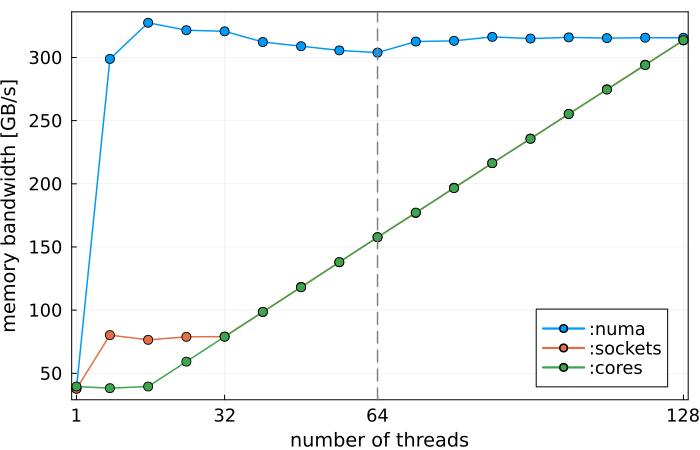

In [15]:
# should take ≈ 5 min
@time axpy_scaling_plot(; numthreads=[1; 8:8:128], N=2^30)